# Get Kaggle dataset

Upload kaggle.json

In [ ]:
 from google.colab import files
 files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"artemkramov","key":"e23e079bd58bf2b260208ca8c5d2d64c"}'}

Copy the JSON file, set permissions, show the list of Kaggle datasets to ensure that the `kaggle` command is working

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets list

Download the dataset and unzip it

In [ ]:
!kaggle competitions download -c airbus-ship-detection

100% 28.6G/28.6G [21:58<00:00, 23.5MB/s]
100% 28.6G/28.6G [21:58<00:00, 23.3MB/s]


In [ ]:
!unzip airbus-ship-detection.zip -d "/content"

In [ ]:
!rm airbus-ship-detection.zip

In [ ]:
import os

print("Number of files in the training folder: {}".format(len(os.listdir("train_v2"))))

Number of files in the training folder: 192556


# Install dependencies and import them

In [ ]:
!pip install transformers
!pip install -q mediapy
!pip install datasets

In [ ]:
import pandas as pd
import os
from transformers import MaskFormerImageProcessor, MaskFormerForInstanceSegmentation, ViTImageProcessor, ViTForImageClassification, AutoImageProcessor
import mediapy as media
from datasets import IterableDataset
from torch.utils.data import DataLoader
import numpy as np
import torch
import tqdm
from skimage.morphology import label
import matplotlib.pyplot as plt

# Set global variables to be used

Mount Google Drive to load the pre-trained model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
BASE_DIR = "/content"
TEST_DIR = os.path.join(BASE_DIR, "test_v2")
TEST_DATASET = os.path.join(BASE_DIR, "sample_submission_v2.csv")
TRAIN_DATASET = os.path.join(BASE_DIR, "train_ship_segmentations_v2.csv")
MODEL_PATH = "/content/drive/MyDrive/Airbus/checkpoints/model_0.8197"
MODEL_PATH_CLASSIFIER = "/content/drive/MyDrive/Airbus/checkpoints_classifier"
WIDTH = 768
HEIGHT = 768

# Prepare the dataset as a generator

In [ ]:
df = pd.read_csv(TEST_DATASET)

In [ ]:
def generator_fn(df_subset):
  """
  Generator to return samples for the test subset
  :param pd.DataFrame df_subset: test subset
  :return: tuple with an image pixels and its ID
  :rtype: (np.ndarray, str)
  """
  for _, row in df_subset.iterrows():
    filename = os.path.join(TEST_DIR, row['ImageId'])
    try:
      image = media.read_image(filename)
      yield np.moveaxis(image, -1, 0), row['ImageId']
    except FileNotFoundError:
      pass

In [ ]:
# Create a dataset from the generator
dataset_test = IterableDataset.from_generator(generator_fn, gen_kwargs={'df_subset': df})

In [ ]:
# Create a preprocessor for the MaskFormer
# The preprocessor transforms the pair "image-mask" to the list of binary masks with the corresponding classes
# We set the ignore_index to -1 as far as we want to predict the background (label=0) as well
preprocessor = MaskFormerImageProcessor(ignore_index=-1, reduce_labels=False, do_resize=False, do_rescale=False, do_normalize=False)

/usr/local/lib/python3.10/dist-packages/transformers/models/maskformer/image_processing_maskformer.py:429: FutureWarning: The `reduce_labels` argument is deprecated and will be removed in v4.27. Please use `do_reduce_labels` instead.
  warnings.warn(


In [ ]:
def collate_fn(batch):
  """
  Preprocess batch data to be suitable for the MaskFormer format
  :param batch: list of tuples (image, label)
  :return: dictionary where each key represents batch value
  :rtype: dict
  """

  # Group image pixels data and their IDs
  inputs = list(zip(*batch))
  images = inputs[0]
  images_idx = inputs[1]

  # Create a pixel masks&values from the list of batch images
  batch = preprocessor(
      images,
      return_tensors="pt",
  )

  # Set IDs of batch images
  batch['ImageId'] = images_idx

  return batch

In [ ]:
# Create the dataloader for the test set
test_dataloader = DataLoader(dataset_test, batch_size=32, shuffle=False, collate_fn=collate_fn)

In [ ]:
# Check if the batch contains all required data
batch = next(iter(test_dataloader))
for k,v in batch.items():
  if isinstance(v, torch.Tensor):
    print(k,v.shape)
  else:
    print(k, v)

pixel_values torch.Size([32, 3, 768, 768])
pixel_mask torch.Size([32, 768, 768])
ImageId ('00002bd58.jpg', '00015efb6.jpg', '00023d5fc.jpg', '000367c13.jpg', '0008ca6e9.jpg', '000a4635f.jpg', '000bd9dbf.jpg', '000f7d875.jpg', '0010551d9.jpg', '001839c6f.jpg', '002a943bf.jpg', '00313b166.jpg', '00327b02d.jpg', '0035268d9.jpg', '003b58a76.jpg', '0044e3dda.jpg', '0046967a4.jpg', '004751507.jpg', '0047c79fc.jpg', '004946ceb.jpg', '004dd347a.jpg', '00506a19e.jpg', '0057c059b.jpg', '005b8152d.jpg', '0063cb1e9.jpg', '00696ecc2.jpg', '006ba5b3b.jpg', '007211988.jpg', '007545acc.jpg', '0075cd3f1.jpg', '007600ece.jpg', '0079b4767.jpg')


# Load a pre-trained model

In [ ]:
model = MaskFormerForInstanceSegmentation.from_pretrained(MODEL_PATH)

Set the GPU device and attach the model to it

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model = model.eval()

Prepare functions to transform the binary mask to the RLE format

In [ ]:
def rle_encode(img):
  """
  Transform binary image to the RLE string
  :param np.ndarray img: binary mask where 1 - mask, 0 - background
  :return: RLE string
  :rtype: str
  """

  # Flatten binary matrix
  pixels = img.T.flatten()

  # Get all pairs of pixels that define the start and the end
  # of non-zero sequences within the pixel array
  pixels = np.concatenate([[0], pixels, [0]])
  runs = np.where(pixels[1:] != pixels[:-1])[0] + 1

  # Replace values that correspond to the end of sequence
  # with a number of elements within a sequence
  runs[1::2] -= runs[::2]

  # Return RLE string
  return ' '.join(str(x) for x in runs)

def multi_rle_encode(img):
  """
  Transform the binary mask to the list of RLE encodings per each predicted ship
  :param np.ndarray img: binary mask
  :return: list of RLE strings per each detected ship
  :rtype: List[str]
  """

  # Split the binary mask into instances
  # Thus, we get a matrix where non-zero value indicates a class number of the predicted object
  labels = label(img)

  # Get RLE encoding fo each instance
  return [rle_encode(labels==k) for k in np.unique(labels[labels>0])]

Predict all test samples, transform output binary masks into RLE format

In [ ]:
# Iterate over all test batches
pred_rows = []
for idx, batch in enumerate(tqdm.tqdm(test_dataloader)):

  # Predict output data
  with torch.no_grad():
    outputs = model(pixel_values=batch["pixel_values"].to(torch.float).to(device))

  # Get expected shapes of binary masks
  target_sizes = [(WIDTH, HEIGHT) for image in batch["pixel_values"]]

  # Predict segmentation maps
  predicted_segmentation_maps = preprocessor.post_process_semantic_segmentation(outputs,
                                                                                target_sizes=target_sizes)


  # Transform each segmentation map of the batch into the RLE format
  # and add retrieved data to the output
  for segmentation_map, image_idx in zip(predicted_segmentation_maps, batch['ImageId']):

    # Get RLE encodings
    rle_encodings = multi_rle_encode(segmentation_map.cpu().detach().numpy())

    # Link encodings with an image
    # and add the pair to the output
    if len(rle_encodings) == 0:
      pred_rows.append({
          'ImageId': image_idx,
          'EncodedPixels': ''
      })
    else:
      for rle_encoding in rle_encodings:
        pred_rows.append({
          'ImageId': image_idx,
          'EncodedPixels': rle_encoding
      })

488it [18:12,  2.24s/it]


In [ ]:
# Represent predicted data as a dataframe
df_pred = pd.DataFrame(pred_rows)
df_pred

,ImageId,EncodedPixels
0,00002bd58.jpg,
1,00015efb6.jpg,
2,00023d5fc.jpg,
3,000367c13.jpg,344078 1 344843 6 345610 7 346378 7 347145 8 3...
4,000367c13.jpg,474714 1 475478 6 476245 8 477013 8 477781 8 4...
...,...,...
25076,ffeb765e8.jpg,119474 5 120242 7 121010 7 121778 7 122547 4
25077,ffeb765e8.jpg,117950 1
25078,ffeb765e8.jpg,94158 2 94926 2 95694 3 96462 3 97230 2
25079,ffeba1475.jpg,


In [ ]:
# Save data as a CSV file for further passing to the Kaggle form
df_pred.to_csv('submission_v1.csv', index=False)

Kaggle results for the first submission `submission_v1.csv`:


*   Private Score `0.67972`
*   Public Score `0.52359`



After analisys of the results, it seems that such a low scores can be explained by the following factors:


*   Test set is highly imbalanced in terms of images without ships (majority class). Such an assumption is made after passing a file with empty masks to Kaggle: the private score is `0.76566`.
*   Model is predicting too many false positives.



# Analysis of results

Check if there are one-pixel ships in the predicted dataset

In [ ]:
def get_pixels_list_from_rle(rle):
  """
  Get the list of selected pixels from the RLE string
  :param str rle: RLE string to be processed
  :return: List of indices of pixels that corresponded to the RLE string
  :rtype: List[int]
  """
  pixels = []
  if rle != '':

    # Split the string by a space symbol
    elements = rle.split(' ')

    # Process pairs (start pixel, number of pixels) therefore
    # we are moving with the size step 2
    for i in range(0, len(elements), 2):
      start = int(elements[i])
      offset = int(elements[i + 1])
      end = start + offset
      pixels.extend(list(range(start, end)))
  return pixels

In [ ]:
def get_num_of_pixels_from_dataset(df_subset):
  num_of_pixels_per_ship = []
  for _, row in df_subset[df_subset.EncodedPixels.notna()].iterrows():
    pixels = get_pixels_list_from_rle(row['EncodedPixels'])
    num_of_pixels_per_ship.append(len(pixels))
  num_of_pixels_per_ship = np.array(num_of_pixels_per_ship)
  return num_of_pixels_per_ship

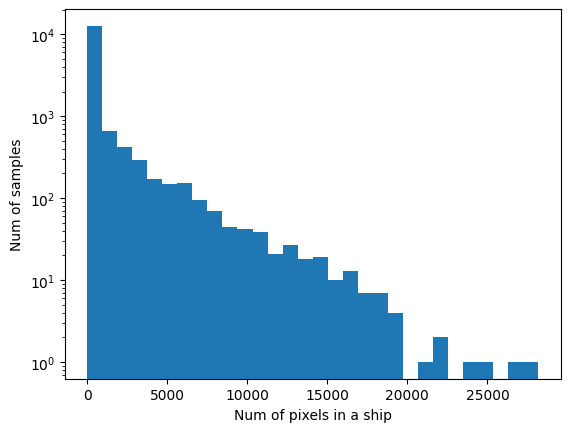

In [ ]:
num_of_pixels_per_ship = get_num_of_pixels_from_dataset(df_pred)
num_of_pixels_per_ship = num_of_pixels_per_ship[num_of_pixels_per_ship != 0]
plt.hist(num_of_pixels_per_ship, bins=30)
plt.yscale('log')
plt.xlabel('Num of pixels in a ship')
plt.ylabel("Num of samples")
plt.show()

In [ ]:
print("Number of 1-pixel ships: {}".format(num_of_pixels_per_ship[num_of_pixels_per_ship == 1].shape[0]))
print("Number of 2-pixel ships: {}".format(num_of_pixels_per_ship[num_of_pixels_per_ship == 2].shape[0]))

Number of 1-pixel ships: 275
Number of 2-pixel ships: 239


Thus, there are some shapes with low number of pixels. Let's check if a training set contains such cases.

In [ ]:
df_train = pd.read_csv(TRAIN_DATASET)
df_train

,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...
...,...,...
231718,fffedbb6b.jpg,NaN
231719,ffff2aa57.jpg,NaN
231720,ffff6e525.jpg,NaN
231721,ffffc50b4.jpg,NaN


In [ ]:
num_of_pixels_per_ship_train = get_num_of_pixels_from_dataset(df_train)

In [ ]:
print("Minimum number of pixels per ship in the training set: {}".format(np.min(num_of_pixels_per_ship_train)))

Minimum number of pixels per ship in the training set: 2


Thus, just a 1-pixel ships may be redundant. As far as such a number of cases is not too big (275 ships), the processing of such cases shouldn't really help. However, it is advisable to try to use a classifier in order to distinguish between images with/without ships.

# Applying a classifier

## Generate the predictions for all test images

The next approach consists in the usage of the classifier in order to filter out images without ships.

In [ ]:
# Load both a preprocessor and the pre-trained model
image_processor_classifier = AutoImageProcessor.from_pretrained(MODEL_PATH_CLASSIFIER)
model_classifier = ViTForImageClassification.from_pretrained(MODEL_PATH_CLASSIFIER)

In [ ]:
# Set the corresponding device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_classifier = model_classifier.to(device)
model_classifier = model_classifier.eval()

In [ ]:
def collate_fn_classifier(batch):
  """
  Prepare function to return batches
  """

  # Group image pixels data and their IDs
  inputs = list(zip(*batch))
  images = inputs[0]
  images_idx = inputs[1]

  images = [np.moveaxis(image, 0, -1) for image in images]

  # Create a pixel masks&values from the list of batch images
  batch = image_processor_classifier(
      images,
      return_tensors="pt",
  )

  # Set IDs of batch images
  batch['ImageId'] = images_idx

  return batch


In [ ]:
# Create a dataloader for the classification
test_dataloader_classification = DataLoader(dataset_test, batch_size=128, shuffle=False, collate_fn=collate_fn_classifier)

In [ ]:
# Check if the batch contains all required data
batch = next(iter(test_dataloader_classification))
for k,v in batch.items():
  if isinstance(v, torch.Tensor):
    print(k,v.shape)
  else:
    print(k, v)

pixel_values torch.Size([128, 3, 224, 224])
ImageId ('00002bd58.jpg', '00015efb6.jpg', '00023d5fc.jpg', '000367c13.jpg', '0008ca6e9.jpg', '000a4635f.jpg', '000bd9dbf.jpg', '000f7d875.jpg', '0010551d9.jpg', '001839c6f.jpg', '002a943bf.jpg', '00313b166.jpg', '00327b02d.jpg', '0035268d9.jpg', '003b58a76.jpg', '0044e3dda.jpg', '0046967a4.jpg', '004751507.jpg', '0047c79fc.jpg', '004946ceb.jpg', '004dd347a.jpg', '00506a19e.jpg', '0057c059b.jpg', '005b8152d.jpg', '0063cb1e9.jpg', '00696ecc2.jpg', '006ba5b3b.jpg', '007211988.jpg', '007545acc.jpg', '0075cd3f1.jpg', '007600ece.jpg', '0079b4767.jpg', '007d5b489.jpg', '007efb5a8.jpg', '0082bf10a.jpg', '0088eb4ba.jpg', '00893e3f7.jpg', '0089d5f39.jpg', '008c483bb.jpg', '008c79db7.jpg', '008f038d3.jpg', '00946da5e.jpg', '00973e661.jpg', '009bc4be5.jpg', '009c7f8ec.jpg', '00a2aca2f.jpg', '00a3a9d72.jpg', '00a3ab3cc.jpg', '00a9fb8a3.jpg', '00aa2fc5b.jpg', '00aa79c47.jpg', '00ad3807a.jpg', '00b2729f6.jpg', '00b40cf94.jpg', '00b5d1608.jpg', '00ba8acbb.j

In [ ]:
# Run the classification model to get predictions for all test samples
classification_rows = []
for batch in tqdm.tqdm(test_dataloader_classification):

  # Get logits
  with torch.no_grad():
    logits = model_classifier(pixel_values=batch['pixel_values'].to(device)).logits

  # Model predicts one of the 2 classes: without ship and with ship
  predicted_labels = torch.argmax(logits, dim=1).cpu().detach().numpy()

  # Add pairs (image, label) to the list
  for label, image_idx in zip(predicted_labels, batch['ImageId']):
    classification_rows.append({
        'ImageId': image_idx,
        'label': label
    })

  # Clear memory
  del logits
  torch.cuda.empty_cache()


122it [04:14,  2.09s/it]


In [ ]:
df_classification = pd.DataFrame(classification_rows)
df_classification.head()

,ImageId,label
0,00002bd58.jpg,0
1,00015efb6.jpg,0
2,00023d5fc.jpg,0
3,000367c13.jpg,1
4,0008ca6e9.jpg,0


In [ ]:
num_images_wo_ships = df_classification[df_classification.label == 0].shape[0]
num_images_total = df_classification.shape[0]
print("Ratio of predicted images without ships: {:.3f}%".format(100 * num_images_wo_ships / num_images_total))

Ratio of predicted images without ships: 76.451%


Ratio of predicted images without ships is big that may confirm the hypothesis of the imbalanced test set that leads to bad Kaggle metrics.

In [ ]:
df_classification.to_csv("classification.csv")

## Clean generated segmentation set according to the predicted classification labels

In [ ]:
# Load the sumbission of the semantic segmentation model
df_pred = pd.read_csv("submission_v1.csv")

In [ ]:
# For all cases when the classifier predicts a "no-ship" label
# we remove all segmentation predictions and set the corresponding field as an empty string
images_wo_ships = df_classification[df_classification.label == 0]['ImageId'].unique()
new_records = []
images_considered = []
for _, row in df_pred.iterrows():
  if row['ImageId'] in images_wo_ships:
    if not (row['ImageId'] in images_considered):
      images_considered.append(row['ImageId'])
      new_records.append({
        'ImageId': row['ImageId'],
        'EncodedPixels': ''
      })
  else:
    new_records.append(row)

In [ ]:
df_pred_filtered = pd.DataFrame(new_records)
df_pred_filtered.head()

,ImageId,EncodedPixels
0,00002bd58.jpg,
1,00015efb6.jpg,
2,00023d5fc.jpg,
3,000367c13.jpg,344078 1 344843 6 345610 7 346378 7 347145 8 3...
4,000367c13.jpg,474714 1 475478 6 476245 8 477013 8 477781 8 4...


In [ ]:
df_pred_filtered.to_csv("submission_v2.csv", index=False)

Kaggle results for the second submission `submission_v2.csv`:


*   Private Score `0.79862`
*   Public Score `0.62482`



As can be seen, the usage of the classifier allowed improving the Kaggle metrics in more than 10%. However, the values of metrics still indicate the available issues that have to be solved.